In [39]:
## COMP9517 Computer Vision Project 20T2
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi


def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded

Train Network? y/n
>  y


/home/arc/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


Epoch: 10


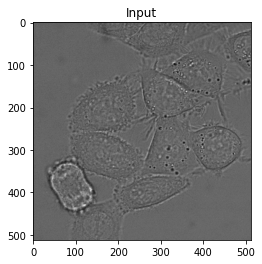

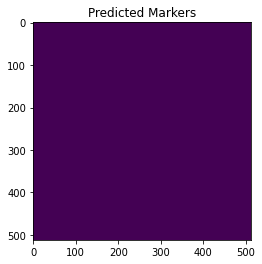

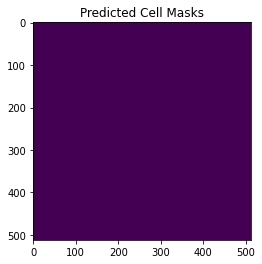

Epoch: 10


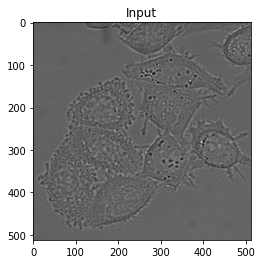

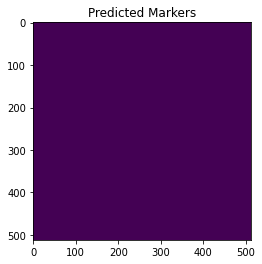

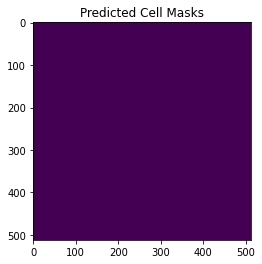

KeyboardInterrupt: 

In [100]:
# Class for creating the CNN
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv = nn.Conv2d(1, 1, 3, padding=1)
        
    def forward(self, x):
        """
        Forward pass through the network
        """
        x = self.conv(x)
        output = F.softmax(x)
        return output


def lossFunction():
    """
    TODO: Implement the Weighted Mean Square Error loss function as per ISBI-final paper
    Currently using Mean Square Error loss
    """
    return F.mse_loss

def load_data(dataset):
    """
    Returns a list of dictionaries containing an image and the corresponding mask
    """
    data = []
    paths = [dataset + '/Sequence 1', dataset + '/Sequence 2']
    for path in paths:
        mask_path = path + ' Masks'
        for f in os.listdir(mask_path):
            if not f.endswith(".tif"):
                continue
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED).astype(np.float32)
            image = cv2.imread(os.path.join(path, f.replace('mask', '')), cv2.IMREAD_GRAYSCALE).astype(np.float32)
            data.append((np.reshape(image, [1, 512, 512]), np.reshape(mask, [1, 512, 512])))
    return DataLoader(data, batch_size=9, shuffle=True)

def train_networks():
    """
    Train 2 networks for predicting markers and the cell mask respectively
    Set trains on data from "Sequence 1 Masks" and "Sequence 2 Masks"
    and save the models
    """
    device = torch.device("cpu")
    
    # Net M predicts the markers. Net C predicts the cell mask
    net_m, net_c = Network().to(device), Network().to(device)
    
    criterion = lossFunction()
    
    # Optimising using Adam algorithm
    optimiser_m = optim.Adam(net_m.parameters(), lr=0.001)
    optimiser_c = optim.Adam(net_c.parameters(), lr=0.001)

    trainLoader = load_data('DIC-C2DH-HeLa')

    # Iterate over a number of epochs on the data
    for epoch in range(100):
        for batch in trainLoader:
            x = batch[0]

            # Clear gradients from last step
            optimiser_m.zero_grad()
            optimiser_c.zero_grad()
            
            # Get target outputs from mask
            ground_truths = np.array(batch[1])
            cell_masks = (ground_truths > 0).astype(np.uint8)
            
            markers = np.zeros((9, 1, 512, 512))
            for i in range(cell_masks.shape[0]):
                marker = disk_erode(cell_masks[i][0])
                markers[i] = np.reshape(marker, [1, 512, 512])
            
            markers = torch.Tensor(markers)
            cell_masks = torch.Tensor(cell_masks)

            # Predict the markers from the image
            output_m = net_m(x)
            loss_m = criterion(output_m, markers)
            loss_m.backward()
            optimiser_m.step()
            
            # Predict the Cell Mask from the image
            output_c = net_c(x)
            loss_c = criterion(output_c, cell_masks)
            loss_c.backward()
            optimiser_c.step()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch: {epoch+1}")
                
                plt.imshow(np.array(x[0][0]), cmap='gray')
                plt.title("Input")
                plt.show()
                
                plt.imshow((output_m[0][0].detach().numpy() > 0.5).astype(np.uint8))
                plt.title("Predicted Markers")
                plt.show()

                plt.imshow((output_c[0][0].detach().numpy() > 0.5).astype(np.uint8))
                plt.title("Predicted Cell Masks")
                plt.show()

    torch.save(net_m.state_dict(), "./CNN_m.pth")
    torch.save(net_c.state_dict(), "./CNN_c.pth")
    print("Saved models.")


train = input("Train Network? y/n\n> ")
if train.lower() == "y":
    train_networks()

In [32]:
def detect_DIC():
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1 Masks'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        plt.title("Ground Truth")
        plt.imshow(image)
        plt.show()
        
        cell_mask = (image > 0).astype(np.uint8)
        plt.imshow(cell_mask)
        plt.show()
        
        markers = disk_erode(cell_mask)
        plt.title("Markers")
        plt.imshow(markers)
        plt.show()
        """
        blurred = cv2.medianBlur(image, 21)
        
        denoised = cv2.fastNlMeansDenoising(blurred, h=3)        
        
        # adaptive normalization - see paper https://is.muni.cz/www/svoboda/ISBI-final.pdf
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        cl1 = clahe.apply(denoised)
        
        mj_filtered = meijering(cl1)
        mj_filtered = custom_thresh(mj_filtered)
        
        kernel = np.ones((4,4),np.uint8)

        eroded = cv2.erode(mj_filtered, kernel, iterations=1)

        thresh = cv2.threshold(eroded, 129, 255, cv2.THRESH_BINARY)[1]

        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        plt.gray()
        plt.imshow(image)
        plt.show()
        
        plt.imshow(blurred)
        plt.show()
        
        plt.imshow(denoised)
        plt.show()
        
        plt.imshow(cl1)
        plt.show()
        
        plt.imshow(mj_filtered)
        plt.show()
        
        plt.imshow(eroded)
        plt.show()
        
        plt.imshow(thresh, cmap='gray')
        plt.show()
        
        plt.imshow(ws_labels)
        plt.show()
        
        #break stops loop after one iteration for debugging
        break
        """
    return

In [33]:
def detect_Fluo():
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        # Threshold at value of 129
        thresh = cv2.threshold(image, 129, 255, cv2.THRESH_BINARY)[1]
        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.gray()
        plt.imshow(thresh, cmap='gray')
        plt.show()
        plt.imshow(image)
        plt.show()
    return

def detect_PhC():
    for filename in fi_list('PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        thresh = cv2.threshold(image, 162, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((4,4),np.uint8)
        # Perform an erosion followed by dilation opening to remove noise
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
        distance = ndi.distance_transform_edt(opening)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.imshow(image, cmap='gray')
        plt.show()
        plt.imshow(opening, cmap='gray')
        plt.show()
        plt.imshow(ws_labels, cmap='gray')
        plt.show()
    return

In [ ]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()